<h1>Customer Segmentation Project</h1>
***
In this project the goal was to identify segments of customers who purchased wine in response email offers for wine discounts. <br><br>
In this type of project, I don't know ahead of time whether any particular customer segments actually exist. This is an example of an "unsupervised learning" problem. There is no outcome or "target" in the data to predict. Instead, I will use algorithms designed to identify the unknown structure in the data, if any exists. <br>
<h2>Why use customer segmentation?</h2>
<br>
In this use case (customers ordering wine in response to an email), why would I want to identify customer segments? I can think of two good reasons:
<ul>
  <li>Focused marketing - If a segment exhibits certain purchasing tendencies or preferences, future offers can be personlized to fit those tendencies </li>
  <li>Steer growth - If some segments produce greater yields than others, future offers or acquisition of customers can focus on appealing to these segments </li>
</ul>

<h2>Overview</h2>
<br>
In this notebook, I walk through all the steps taken to perform customer segmentation. For the segmentation analysis, I will use K-means clustering, a popular algorithm that works pretty well "out of the box" for many unsupervised learning problems. 

First I import a few libraries and tools to use in the rest of the analysis. 

In [1]:
import pandas as pd
import numpy as np
# plotting tools
%matplotlib inline
from plotnine import *
# scikit learn libraries for the analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Importing the dataset

This dataset has two tables of data stored in an excel file. I start by importing the data and viewing a few records to understand the type of data I'm dealing with. 

The first table contains data on each wine e-mail offer sent to customers.

In [2]:
offers = pd.read_excel("data/wine.xlsx", sheet_name=0)
offers.columns = ["offer_id", "month", "varietal", "min_qty", "discount", "origin", "past_peak"]
print offers.shape
offers.head()

(32, 7)


,offer_id,month,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


The "offers" data contains information about 32 offers. Each offer has an ID number, the month of the campaign, the wine varietal, the minimum quantity for the purchase, the discount amount, the country of origin, and whether the wine is past its peak or not. 

The second table contains data on customer orders. 

In [3]:
orders = pd.read_excel("data/wine.xlsx", sheet_name=1)
orders.columns = ["name", "offer_id"]
#df_transactions['n'] = 1
print orders.shape
orders.head()

(324, 2)


,name,offer_id
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26


The "orders" data includes 324 orders, with each row containing the customer name and offer ID for each order. 

## Exploring the dataset
Before I start the customer segmentation analysis, I want to become more familiar with the dataset, by doing some basic data exploration and visualization.

First I examine the orders data. Here I group the data by customer, count the number of orders per customer, and return some basic summary statistics. 

In [4]:
print orders.groupby('name')['offer_id'].count().describe()

count    100.000000
mean       3.240000
std        1.608814
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        9.000000
Name: offer_id, dtype: float64


The dataset has 100 customers, with an average of 3.24 orders per customer, ranging from 1-9 orders per customer. 

Next I examine the offers data. The data contains a few columns I can use to group the data, such as the month of the offer, the varietal, and the country of origin. For each factor, I'll count the offers by group and plot the totals. 

In [5]:
# function to plot histogram, given the column name
def plot_hist(c='colname'):
    plottitle = 'Offer count by ' + c
    plt = ggplot(offers) + aes(x=c) + geom_histogram(binwidth=1)
    return plt + coord_flip() + ggtitle(plottitle)

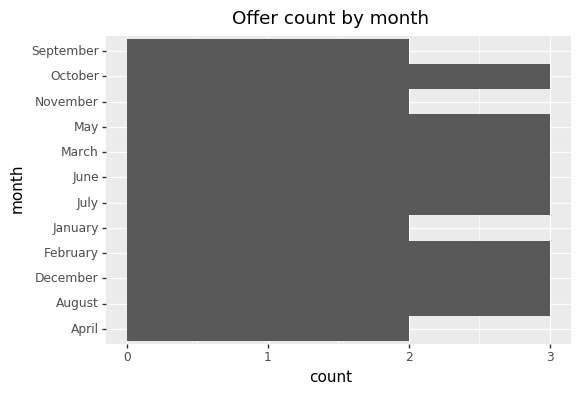

<ggplot: (32663282)>

In [6]:
plot_hist(c='month')

The offers are sent with consistent frequency, at about 2-3 offers per month. 

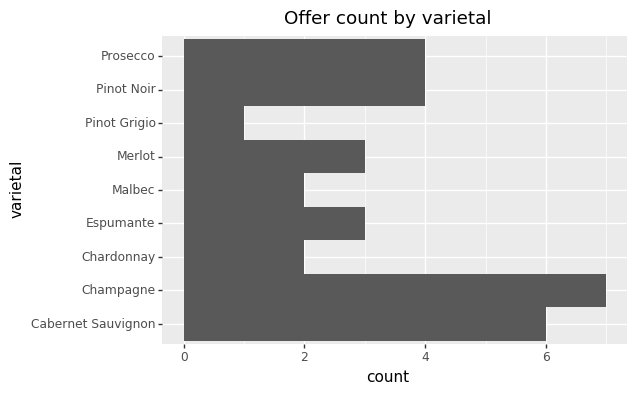

<ggplot: (32763024)>

In [7]:
plot_hist(c='varietal')

Champagne and Cab make up the most common offers, followed by Prosecco and Pinot Noir.  

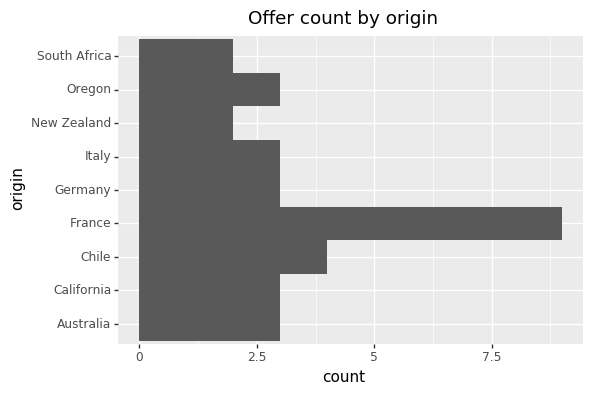

<ggplot: (32785777)>

In [8]:
plot_hist(c='origin')

French wines comprise the most offers sent with 9, while no other origins have more than 4. 

The offers data also includes two continuous variables, discount amount and minimum quantity. Here I group the data by varietal, and display the mean, min, and max of these variables for each varietal.

In [9]:
def plot_cont(c='colname'):
    plottitle = 'Mean, min, and max of ' + c
    plt = ggplot(aes(x='varietal', y=c), data=offers) + stat_summary(
        fun_y = np.mean, fun_ymin=np.min, fun_ymax=np.max) 
    return plt + coord_flip() + ggtitle(plottitle)

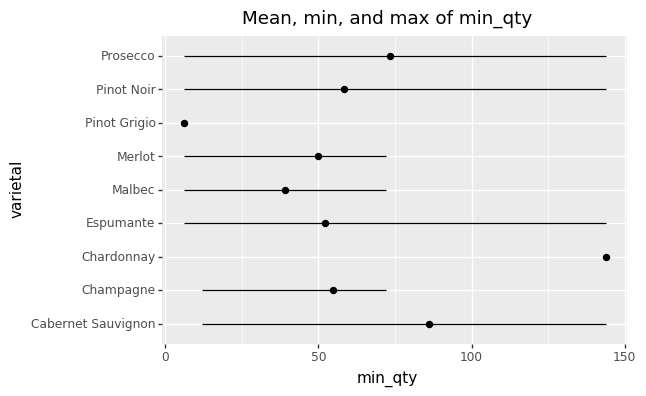

<ggplot: (32864036)>

In [10]:
plot_cont(c='min_qty')

Most varietals have average minimum quantity close to 50. Chardonnay is an outlier, with those 2 offers close to 150. 

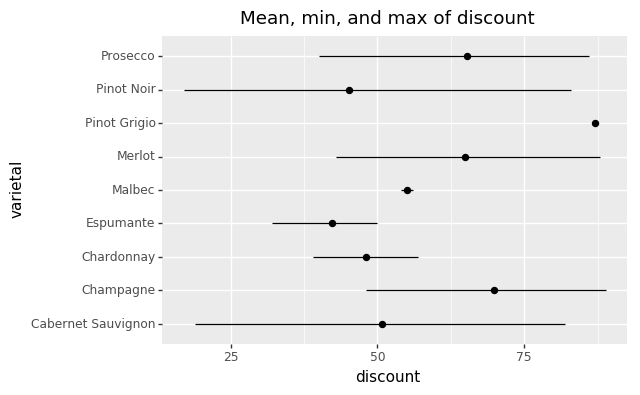

<ggplot: (34334251)>

In [11]:
plot_cont(c='discount')

The average discount amount is between 40-75 for almost every varietal. Pinot Grigio (only one offer), Champagne, Merlot, and Prosecco have the highest average discounts. Espumante and Chardonnay had the lowest average discount and also the lowest max discount. 

<h2>Data Exploration: Insights</h2><br>
With just a few lines of code I have gained a few good high-level impressions about the dataset. 
- Each month has 2-3 offers. 
- The total number of offers for each varietal range from 1 (Pinot Grigio) to 7 (Champagne).
- The most offers come from French wines, which had 9 offers. All other countries only had 2-4 offers each.  
- There's a wide range of discounts for each offer, with some varietals having a much higher average discount than others. 

I haven't begun to identify customer segments yet, so why did I need to explore the data like this? Because now I know the context or background of the data, and can interpret the customer segments with this context in mind. For example, I know Chardonnay had both a high minimum quantity and a lower discount amount, a combination of factors that make Chardonnay a less attractive option. Now, if I see a segment that buys alot of Chardonnay, I think these customers must really like Chardonnay!

<h2>Customer segmentation</h2>

With segmentation, I will use the customers' purchasing behavior to try to group similar customers together.  

First I transform the data to create a matrix that indicates whether the customer purchased each offer. This is the format I need to input the data to the clustering algorithm. 

In [12]:
# merge the offer and order data
orders['n'] = 1
df = pd.merge(offers, orders, on='offer_id', how='outer')
dfpv = pd.pivot_table(df, index=['name'], values=['n'], 
               columns=['offer_id'], aggfunc=np.sum, fill_value=0)
dfpv.head()

n                            ...                              
offer_id 1  2  3  4  5  6  7  8  9  10 ... 23 24 25 26 27 28 29 30 31 32
name                                   ...                              
Adams     0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  1  1  0  0
Allen     0  0  0  0  0  0  0  0  1  0 ...  0  0  0  0  1  0  0  0  0  0
Anderson  0  0  0  0  0  0  0  0  0  0 ...  0  1  0  1  0  0  0  0  0  0
Bailey    0  0  0  0  0  0  1  0  0  0 ...  0  0  0  0  0  0  0  1  0  0
Baker     0  0  0  0  0  0  1  0  0  1 ...  0  0  0  0  0  0  0  0  1  0

[5 rows x 32 columns]

This dataframe now has each customer as a row and each column as an offer, with the cell indicating whether the customer purchased that offer or not. With the data in this format, I can now use K-means clustering to segment the customers. 

<h2>Clustering algorithm: K-Means Clustering</h2>

With K-Means clustering the goal is essentially to create groups of customers so that the customers in each group are similar to each other, and dissimilar from customers in other groups. I don't know ahead of time which "true" customer segments exist, how many segments exist, what types of customers make up each segment. This algorithm will look for patterns in the purchase matrix above to group "like" customers together. 

With K-means clustering, I have to tell the algorithm the number of clusters to form. Because I don't know the best number for this data, I'll test different numbers of clusters and use a scoring method to see how well each solution groups the data. The silhouette score summarizes how well each data point "fits" its assigned cluster <em>and</em> how poorly it fits into other clusters. The scores range from -1 to 1, with scores closer to 1 indicative of a better clustering solution. 

In [13]:
data = dfpv.values
clusters=range(2,11)
scores = []

for n in clusters:
    kmod = KMeans(n_clusters=n, random_state=10)
    cluster_labels = kmod.fit_predict(data)
    score = silhouette_score(data, cluster_labels)
    scores.append(score)

Having obtained the scores for solutions with 2-11 clusters, I plot the scores to see which solution has the highest score. 

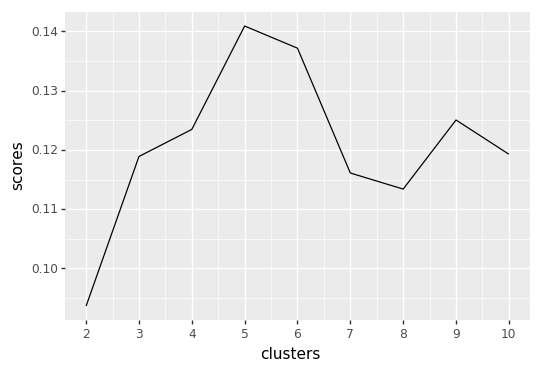

<ggplot: (34801328)>

In [14]:
dfscores = pd.DataFrame({'clusters': clusters, 'scores': scores})
ggplot(aes(x='clusters', y='scores'), data=dfscores) + geom_line() + scale_x_continuous(breaks=dfscores.clusters)

The solution with 5 clusters produces the best silhouette score. The scores increase steadily from 2 to 5 but decrease after 5.

<h2>Examining the Segments</h2>

At this point all I know is that the customers fall into 5 segments. I don't know anything about the segments or the customers in each segment. 

To learn more about the segments and the customers in each segment, I'll use more data visualization. This should help me see the unique characteristics of each segment and understand why customers were grouped together. 

First I need to link each customer with their assigned segment.

In [15]:
# # use 5-cluster solution
# obtain the cluster assignments and scores for each customer
kmod = KMeans(n_clusters=5, random_state=10)
clusters = list(kmod.fit_predict(data))
dfk5 = pd.DataFrame({'name': dfpv.index, 
                     'cluster': clusters})

Here I plot the percentage of all customers that fall into each segment. Each segment is identified by a number from 0-4, which is arbitrary at this point. 

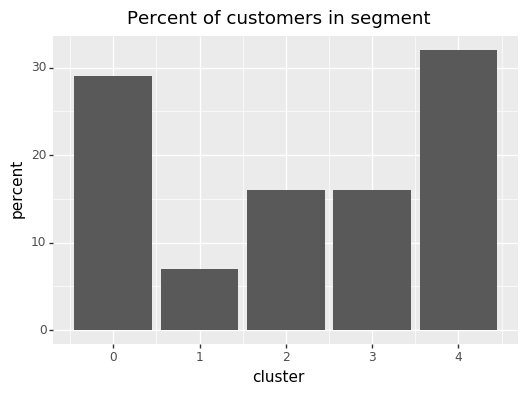

<ggplot: (34830052)>

In [16]:
rows = dfk5.shape[0]
dfk5pct = dfk5.groupby('cluster', as_index=False)['name'].count()
dfk5pct['percent'] = (dfk5pct['name'] / rows) * 100
t = "Percent of customers in segment"
ggplot(aes(x='cluster', y='percent'), data=dfk5pct) + geom_col() + ggtitle(t)

The smallest segment (#1) is only around 7% of the customers, two segments are equal at around 16% (#2 and #3), while segment #0 and #4 are the largest at around 30% each. 

<h2>Defining the Segments</h2>
<br>
The clustering algorithm used the customer-purchase matrix to identify the segments, but to define the segments I'll return to the original offers data that contained the details about the offers, like the varietal, the region, etc. By visualizing this  data in relation to the customer segments, I should be able to identify some reasons why customers were grouped together. 

My first idea is to look at the varietals, thinking that the segments might each have a unique pattern of varietal purchasing. 

First I transform the orders and offers data to compute the number of each varietal purchased by each customer. 

In [17]:
# group offer/order data by customer and varietal and count
df_temp = df.groupby(['name', 'varietal'], as_index=False)['n'].count()
# pivot data to get some of varietal orders for each customer
df_varcnt = pd.pivot_table(df_temp, index=['name'], values=['n'], 
               columns=['varietal'], aggfunc=np.sum, fill_value=0)
# remove indexes created by pivot
df_varcnt.columns = df_varcnt.columns.droplevel()
del df_varcnt.columns.name
df_varcnt.reset_index(inplace=True)
# merge the pivot table with the customer clusters
dfk5vars = pd.merge(dfk5, df_varcnt, how='inner', on='name') 
dfk5vars.head()

,cluster,name,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
0,0,Adams,0,0,0,1,1,0,1,0,0
1,4,Allen,0,1,1,0,0,0,0,0,0
2,2,Anderson,0,0,0,0,0,0,0,2,0
3,0,Bailey,0,0,0,0,1,0,0,0,1
4,3,Baker,0,2,0,0,0,0,0,0,2


This dataset now contains the segment, customer, and count of each varietal type ordered by each customer. I'll aggregate the data further by computing the average number of orders of each varietal for each segment. 

In [18]:
dfk5_varmeans = dfk5vars.groupby('cluster').mean().transpose()
dfk5_varmeans.index.name = 'varietal'
dfk5_varmeans.reset_index(inplace=True)
del dfk5_varmeans.columns.name

Finally, I'll create a function to plot the mean value for each segment, which should illustrate whether the segments do indeed exhibit distinct patterns of varietal purchasing.  

In [19]:
def plot_cluster(c=0, seg="Segment"):
    d = dfk5_varmeans.loc[:, ['varietal', c]]
    d.columns = ['varietal', 'mean']
    p = ggplot(aes(x='varietal', y='mean'), data=d) + geom_col() + coord_flip() + ggtitle(
        seg) + labs(y = 'Average orders per customer', x = '') + scale_y_continuous(limits=(0,3))
    return p

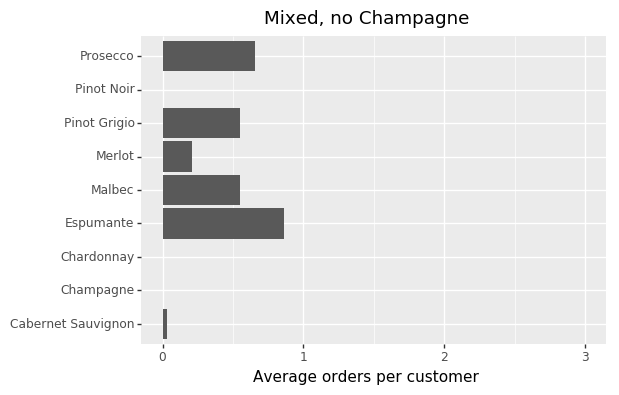

<ggplot: (34829909)>

In [20]:
plot_cluster(c=0, seg="Mixed, no Champagne")

<h3>Segment 0 - "Mixed, no Champagne"</h3>

These customers ordered no Pinot Noir, Chardonnay, or Champagne, and some of just about everything else. I refer to them as <strong>"Mixed, no Champagne"</strong>, because as you'll see below, they're the only segment that ordered zero Champagne.

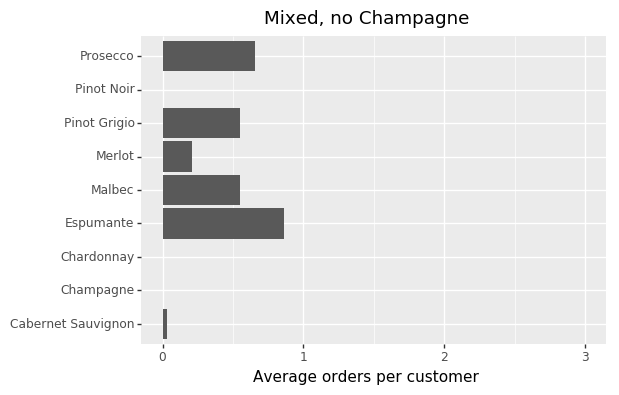

<ggplot: (34325291)>

In [21]:
plot_cluster(c=0, seg="Mixed, no Champagne")

<h3>Segment 1 - "Sparkling"</h3>

I call Segment 1 the <strong>"Sparkling"</strong> segment: they ordered sparkling wines, and literally nothing else.  

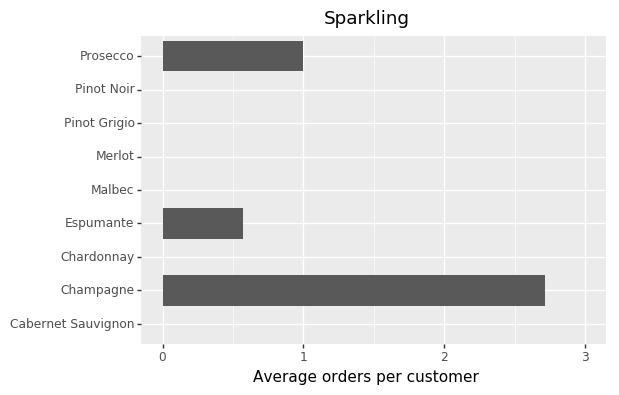

<ggplot: (32666439)>

In [22]:
plot_cluster(c=1, seg="Sparkling")

<h3>Segment 2 - "Pinot Noir"</h3>

Segment 2 is clearly the <strong>Pinot Noir</strong> segment. They ordered Pinot Noir and hardly anything else. 

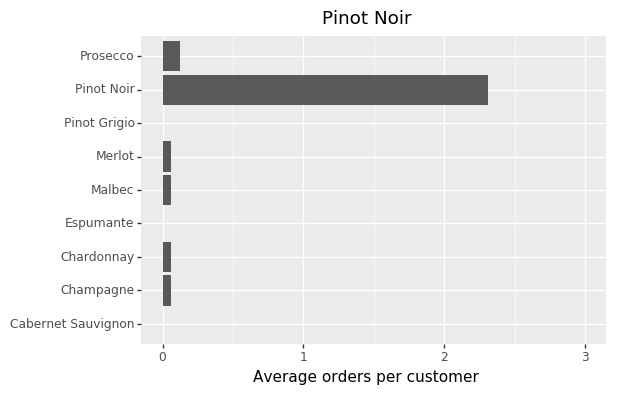

<ggplot: (34325336)>

In [23]:
plot_cluster(c=2, seg="Pinot Noir")

<h3>Segment 3 - "Mixed, Heavy Champagne"</h3>

I call Segment 3 <strong>"Mixed, Heavy Champagne"</strong>. They ordered Champagne in relatively high amounts (average of 2 orders each), but dabbled in a few other varietals as well. 

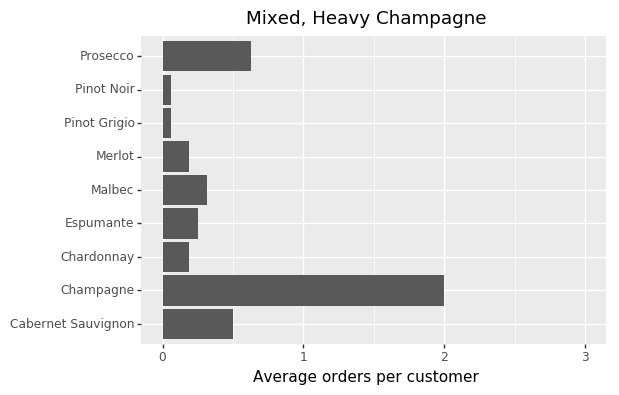

<ggplot: (32864095)>

In [24]:
plot_cluster(c=3, seg="Mixed, Heavy Champagne")

<h3>Segment 4 - "Mixed, All"</h3>

Segment 4 could be called <strong>"Mixed, All"</strong>. Like the "Mixed, Heavy Champagne" segment, this segment ordered more Champagne than other varietals, but ordered nearly as much Cab as Champagne, and relatively more of other varietals as well. They didn't order literally "All" of the varietals (no Pinot Grigio), but as a shorthand, it works. 

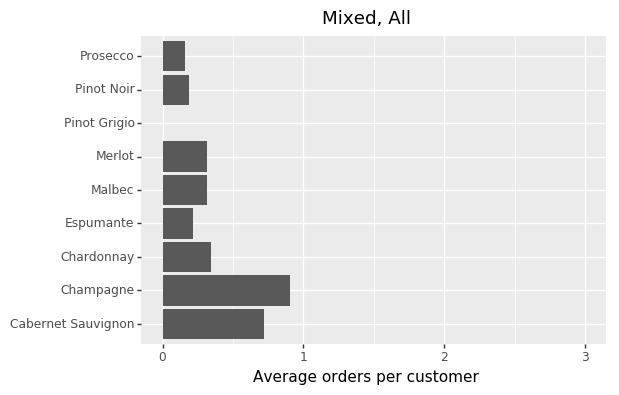

<ggplot: (34415283)>

In [25]:
plot_cluster(c=4, seg="Mixed, All")

<h2>Using the Segments</h2>
Now that the segments are defined, how might we use them to make a business decision?

The segments vary in size, and each segment is responsible for some amount of the orders. I can use this data to figure out which segments the client should target to increase sales. 

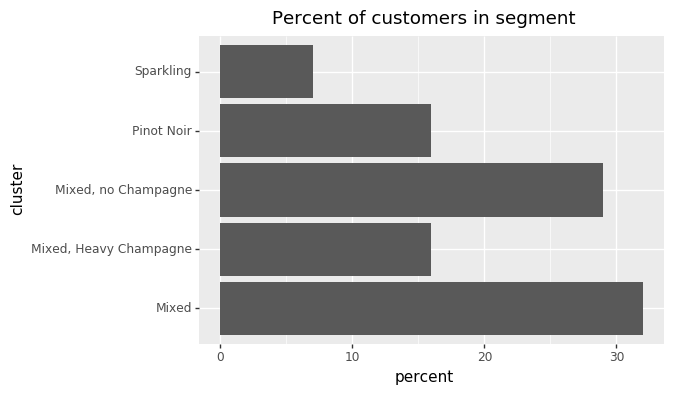

<ggplot: (34417440)>


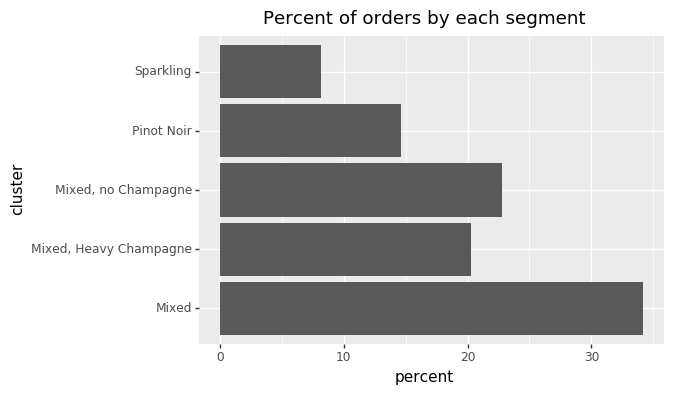

<ggplot: (37822338)>

In [26]:
clabs = ['Mixed, no Champagne', 'Sparkling', 'Pinot Noir', 'Mixed, Heavy Champagne', 'Mixed']
# show the segment size plot
dfk5pct['cluster'] = clabs
t = "Percent of customers in segment"
print ggplot(aes(x='cluster', y='percent'), data=dfk5pct) + geom_col() + ggtitle(t) + coord_flip()

# create and show plot of segment order percent
dfk5vars['total'] = dfk5vars.iloc[:, 2:10].sum(axis=1)
dfk5varpct = dfk5vars.groupby('cluster')['total'].sum() / dfk5vars['total'].sum() * 100
dfk5varpct = pd.DataFrame(dfk5varpct).reset_index()
dfk5varpct['cluster'] = clabs

dfk5varpct.rename(columns={'total': 'percent'}, inplace=True)
t = "Percent of orders by each segment"
ggplot(aes(x='cluster', y='percent'), data=dfk5varpct) + geom_col() + ggtitle(t) + coord_flip()

Another important metric to consider is the return on each customer within each segment. Here I plot the average number of orders per customer within each segment. 

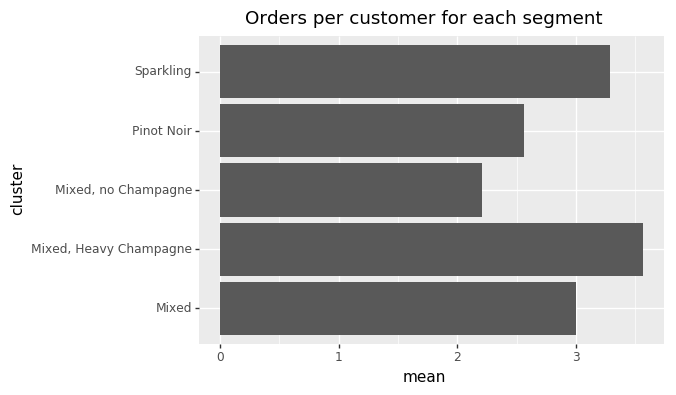

<ggplot: (34417493)>

In [27]:
dfk5varmean = dfk5vars.groupby('cluster')['total'].mean()
dfk5varmean = pd.DataFrame(dfk5varmean).reset_index()
dfk5varmean['cluster'] = clabs
dfk5varmean.rename(columns={'total': 'mean'}, inplace=True)
t = "Orders per customer for each segment"
ggplot(aes(x='cluster', y='mean'), data=dfk5varmean) + geom_col() + ggtitle(t) + coord_flip()

With these two plots I gain a few important insights about the segments and orders:
- The "Mixed" and "Mixed, no Champagne" segments are similar in size, but the "Mixed" segment accounts for far more orders (34% versus 23%). 
- Although the "Mixed, Heavy Champagne" segment is about half the size as the "Mixed, no Champagne" segment, they account for a similar percentage of the orders. 

The main takeaway is that taking into account the segment size, the Champagne-ordering segments account for relatively greater proportions of the orders than the no-Champagne segments. 

Another important metric to consider is the return on each customer within each segment. Here I plot the average number of orders per customer within each segment. 

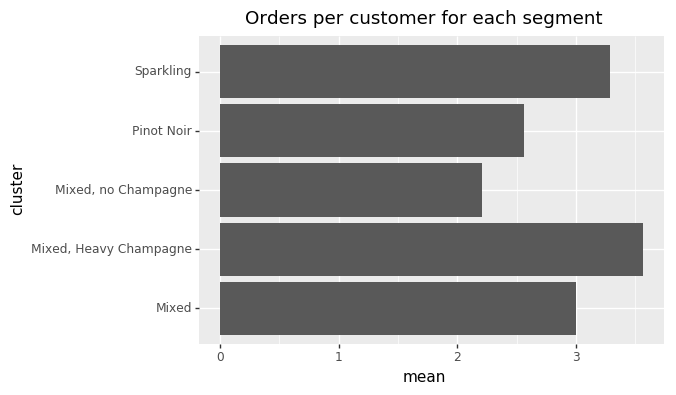

<ggplot: (37937615)>

In [28]:
dfk5varmean = dfk5vars.groupby('cluster')['total'].mean()
dfk5varmean = pd.DataFrame(dfk5varmean).reset_index()
dfk5varmean['cluster'] = clabs
dfk5varmean.rename(columns={'total': 'mean'}, inplace=True)
t = "Orders per customer for each segment"
ggplot(aes(x='cluster', y='mean'), data=dfk5varmean) + geom_col() + ggtitle(t) + coord_flip()

This plot confirms what I already suspected: the segments who order champagne produce the most orders on a per-customer basis. 

In [29]:
dfk5varmean

,cluster,mean
0,"Mixed, no Champagne",2.206897
1,Sparkling,3.285714
2,Pinot Noir,2.562500
3,"Mixed, Heavy Champagne",3.562500
4,Mixed,3.000000


<h2> Summary and Recommendations</h2>



The customers fall into 5 segments that can be characterized by the varietals they ordered. In order of size, the segments are:
<ul>
  <li>Mixed (32%) - A mix of all varietals, most often Champagne and Cabernet Sauvignon</li>
  <li>Mixed, no Champagne (29%) - A mix of a few varietals, but no Champagne, Chardonnay, Pinot Noir, and rarely Cab </li>
  <li>Mixed, Heavy Champagne (16%) - A mix of all varietals but especially Champagne</li>
  <li>Pinot Noir (16%) - Pinot Noir and very rarely anything else</li> 
  <li>Sparkling (7%) - Only varietals that come in sparkling form</li>
</ul>

The champagne-ordering segments return the most orders per customer, led by the Mixed, Heavy Champagne segment (3.5 orders). 
<br>The non-Champagne segments return the fewest orders per customer. The Mixed, no Champagne segment had the lowest order rate (2.2 orders/customer), and is also the second-largest segment.

Based on this analysis, I recommend that the company personalize future offers to fit each segment's purchasing tendencies, as follows:
<ul>
  <li>Sparkling wine segment - Only sparkling wines</li>
  <li>Pinot Noir segment - Only Pinot Noir</li>
  <li>Mixed, no Champagne segment - A mix of varietals not including Champagne, Chardonnay, or Pinot Noir</li>
  <li>Mixed and Mixed, Heavy Champagne segments - A mix of varietals with an emphasis on Champagne</li> 
</ul>

I also recommend that the company focus customer acquisition efforts on new customers that buy champagne, since segments with these customers tend to produce the greatest return per customer. 